Notebook to:
* Read Embedded Element Patterns for a range of station rotations.
* Back-rotation the patterns.
* Display the results.

It requires local copies of the EEP files. These should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.<br>
e.g.
    
> from ska_low_mccs_calibration.eep import convert_eep2npy<br>
> convert_eep2npy(f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat", npy_dir="./AAVS3_EEPs_local")<br>

In [1]:
# Imports

import logging
import sys

import matplotlib.pyplot as plt
import numpy as np

from ska_low_mccs_calibration.eep import (
    load_eeps,
    resample_eeps,
    station_rotation_matrix,
)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
# Load EEPs
# Requires a local copy of the FEKO models, converted to .npy format as described in
# https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html
# e.g.
#     from ska_low_mccs_calibration.eep import convert_eep2npy
#     convert_eep2npy(
#         f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat",
#         npy_dir="./AAVS3_EEPs_local",
#     )

eep_file_path = "./AAVS3_EEPs_local"
eep_file_base = "FEKO_AAVS3_vogel_256_elem_50ohm_"

# frequency channel to read
channel_id = 140
channel_bw_MHz = 400.0 / 512.0
frequency_MHz = float(channel_id) * channel_bw_MHz

raw_EEPs = load_eeps(frequency_MHz, eep_file_path)

In [3]:
# Setup for resampling and plotting

# New sky coordinates
az_deg = np.arange(0, 360, 2)
el_deg = np.arange(0, 90, 2)
Naz = len(az_deg)
Nel = len(el_deg)
azimuth_deg, elevation_deg = np.meshgrid(az_deg, el_deg)
azimuth_deg = azimuth_deg.flatten()
elevation_deg = elevation_deg.flatten()

def plotEEP(nrow, ncol, panel, img, label):
    ax = plt.subplot(nrow, ncol, panel, polar=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(label)
    plt.pcolormesh(
        np.pi / 2 - azimuth_deg[:Naz] * np.pi / 180.0,
        np.pi / 2 - elevation_deg[::Naz] * np.pi / 180.0,
        np.abs(img),
    )
    plt.colorbar(orientation="horizontal")

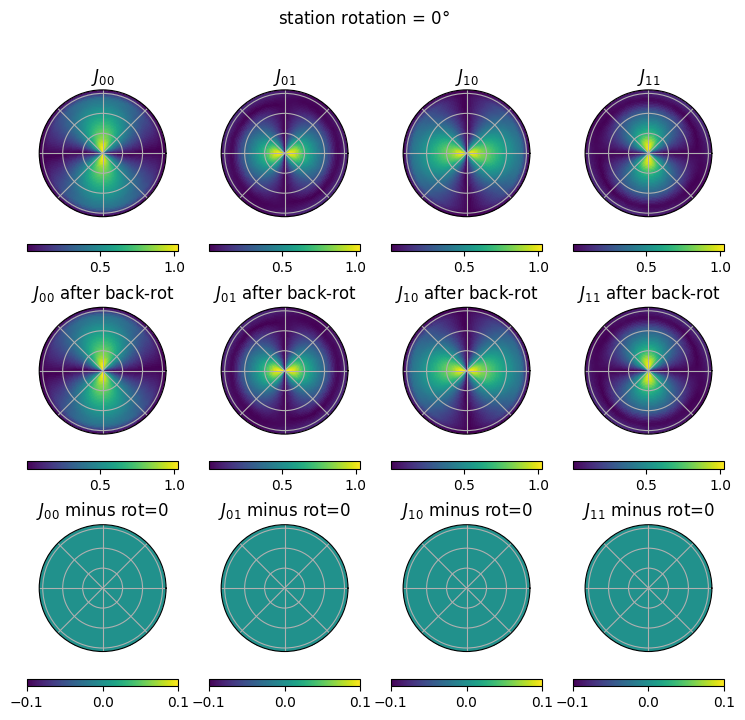

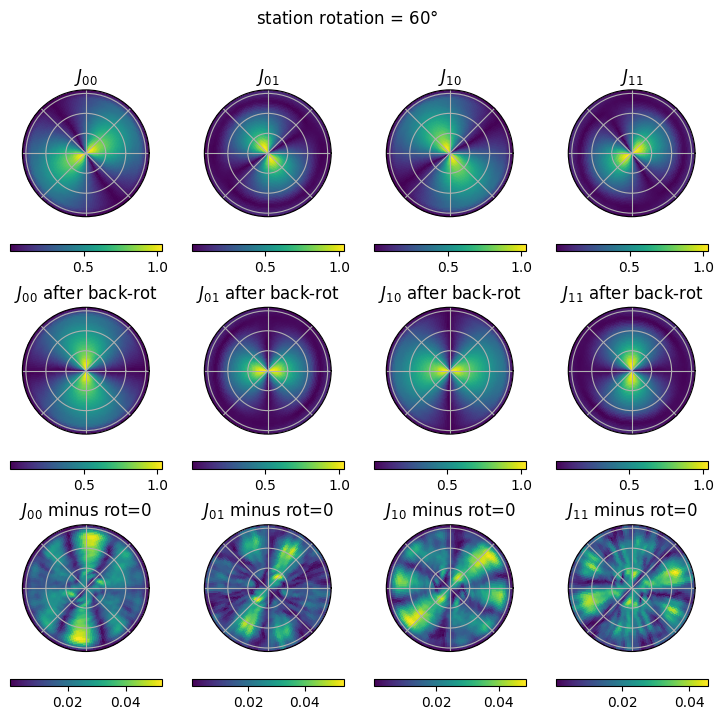

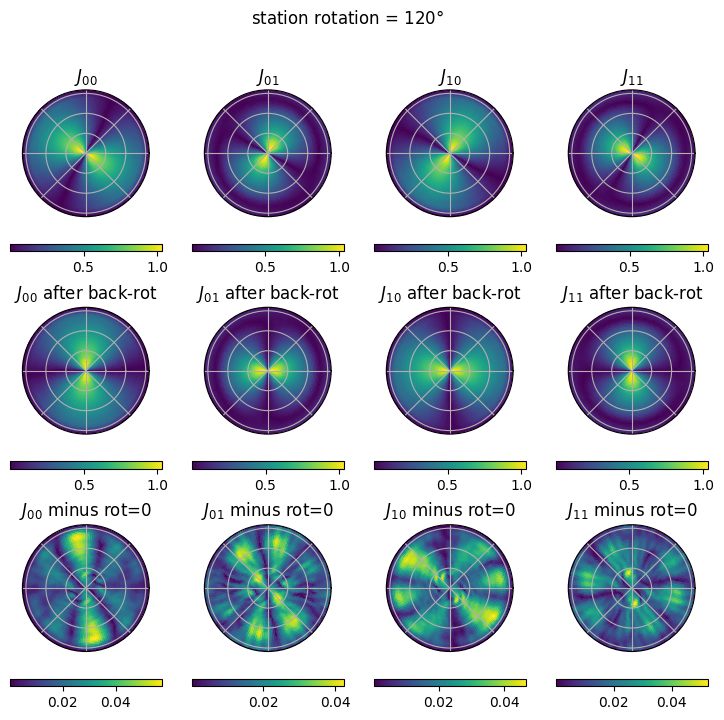

In [5]:
# Resample and plot for different EEP rotations

for k, rotation in enumerate(range(0, 180, 60)):

    EEPs = resample_eeps(raw_EEPs, rotation, azimuth_deg, elevation_deg)

    # average over stations (cf. beamforming), transpose to put pol axis last, then reshape
    J = np.mean(np.array(EEPs), axis=1).T.reshape(Nel, Naz, 2, 2)

    # apply back rotation
    R = station_rotation_matrix(rotation, reverse=True)
    Jback = np.einsum("px,...xq->...pq", R, J)

    # plot results
    fig = plt.figure(figsize=[9, 8])
    fig.suptitle(fr"station rotation = {rotation}$\degree$", fontsize=12)

    plotEEP(3, 4, 1, J[:,:,0,0], r"$J_{00}$")
    plotEEP(3, 4, 2, J[:,:,0,1], r"$J_{01}$")
    plotEEP(3, 4, 3, J[:,:,1,0], r"$J_{10}$")
    plotEEP(3, 4, 4, J[:,:,1,1], r"$J_{11}$")

    plotEEP(3, 4, 5, Jback[:,:,0,0], r"$J_{00}$ after back-rot")
    plotEEP(3, 4, 6, Jback[:,:,0,1], r"$J_{01}$ after back-rot")
    plotEEP(3, 4, 7, Jback[:,:,1,0], r"$J_{10}$ after back-rot")
    plotEEP(3, 4, 8, Jback[:,:,1,1], r"$J_{11}$ after back-rot")

    # save the unrotated patterns for comparison
    if k == 0:
        J0 = J.copy()

    plotEEP(3, 4,  9, Jback[:,:,0,0] - J0[:,:,0,0], r"$J_{00}$ minus rot=0")
    plotEEP(3, 4, 10, Jback[:,:,0,1] - J0[:,:,0,1], r"$J_{01}$ minus rot=0")
    plotEEP(3, 4, 11, Jback[:,:,1,0] - J0[:,:,1,0], r"$J_{10}$ minus rot=0")
    plotEEP(3, 4, 12, Jback[:,:,1,1] - J0[:,:,1,1], r"$J_{11}$ minus rot=0")

# plt.savefig("EEP_back_rotation.png", dpi=300, format="png")